In [5]:
using Pkg; Pkg.activate(".")
using SteinMD
using Molly 
using PotentialLearning
using LinearAlgebra

  Activating project at `~/cesmix/exploratory/new_public/molly/steinmd_expts`


┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt /Users/swyant/.julia/packages/Flux/ljuc2/ext/FluxCUDAExt/FluxCUDAExt.jl:57


In [6]:
include("/Users/swyant/cesmix/dev/SteinMD.jl/src/makie/makie.jl")

plot_trigger_hist (generic function with 1 method)

In [7]:
ref = MullerBrown()

MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}[-200.0 kJ mol⁻¹, -100.0 kJ mol⁻¹, -170.0 kJ mol⁻¹, 15.0 kJ mol⁻¹], Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}[-1.0 nm⁻², -1.0 nm⁻², -6.5 nm⁻², 0.7 nm⁻²], Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}[0.0 nm⁻², 0.0 nm⁻², 11.0 nm⁻², 0.6 nm⁻²], Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}[-10.0 nm⁻², -10.0 nm⁻², -6.5 nm⁻², 0.7 nm⁻²], Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[1.0 nm, 0.0 nm, -0.5 nm, -1.0 nm], Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋,

In [22]:
# define properties
atom_mass = 1.0u"g/mol"
boundary = RectangularBoundary(Inf*u"nm")
temp = 100.0u"K"

# define initial system
#atoms = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1")] # Do you need to specify the LJ params?
atoms = [Atom(mass=atom_mass)] # No, I don't think so
coords = [SVector(-0.8, 1.2)u"nm"] # initial position
sys = System(
    atoms=atoms,
    coords=coords,
    boundary=boundary,
    general_inters=(ref,),
    loggers=(coords=CoordinateLogger(100; dims=2),),
)

# define simulator
sim_langevin = OverdampedLangevin(
            dt=0.002u"ps",
            temperature=temp,
            friction=4.0u"ps^-1")

OverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, 100.0 K, 4.0 ps⁻¹, 1)

In [23]:

# run simulation - this will take a few seconds
simulate!(sys, sim_langevin, 5_000_000)

System with 1 atoms, boundary RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[Inf nm, Inf nm])

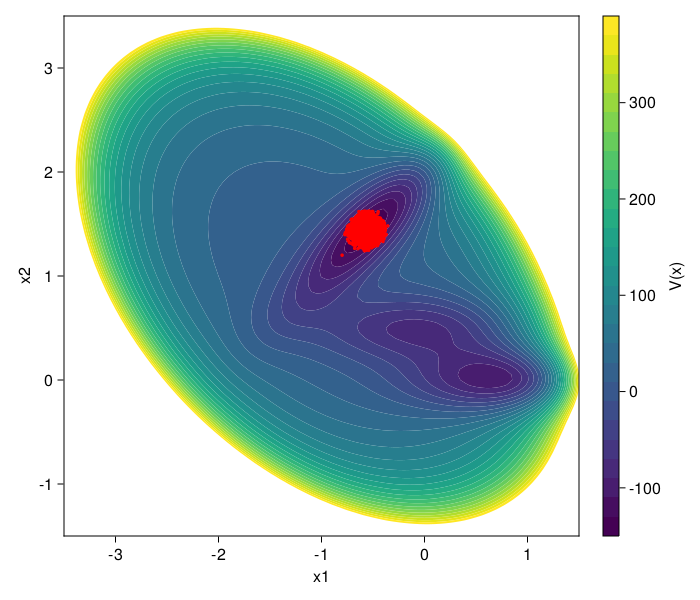

In [24]:
# plot MD trajectory 
dist_units = u"nm"
xcoords = Vector(-3.5:0.05:1.5) .* dist_units
ycoords = Vector(-1.5:0.05:3.5) .* dist_units
ctr_grid = [xcoords, ycoords]
ctr_lvls = -150:20:400

f0 = plot_md_trajectory(sys, ctr_grid, fill=true, lvls=ctr_lvls)

In [80]:
# define kernel
#rbf = RBF(Euclidean(2), β=1.0, ℓ = 0.1) 
rbf = RBF(Euclidean(2), β=1.0, ℓ = 1.0) 
# define simulator
sim_svgd = StochasticSVGD(
            dt=0.002u"ps",
            kernel=rbf,
            #temperature=temp, # 1.0u"K",
            temperature=200.0u"K", 
            friction=1.0u"ps^-1")

StochasticSVGD{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, RBF, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, RBF(Euclidean{Float64}([1.0 0.0; 0.0 1.0], [1.0 0.0; 0.0 1.0]), 1.0e-8, 1.0, 1.0), 200.0 K, 1.0 ps⁻¹, 1)

In [81]:
# subsample to obtain training data
coords_train = [sys.loggers.coords.history[i][1] for i = 2:2000:length(sys.loggers.coords.history)]
ntrain = length(coords_train)
atoms_train = [Atom(mass=atom_mass) for i in 1:ntrain]

# define initial ensemble
ens1 = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(ref,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
    loggers=(
        coords=CoordinateLogger(1; dims=2),
        ksd=StepComponentLogger(1; dims=2),
    )
) for (atoms_i, coords_i) in zip(atoms_train, coords_train)]

25-element Vector{System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, NamedT

In [82]:
# run simulation - this will take a few seconds
simulate!(ens1, sim_svgd, 10_000) # Note number of simulations chosen to lead to roughly equivalent sim run times as running the full trajectory

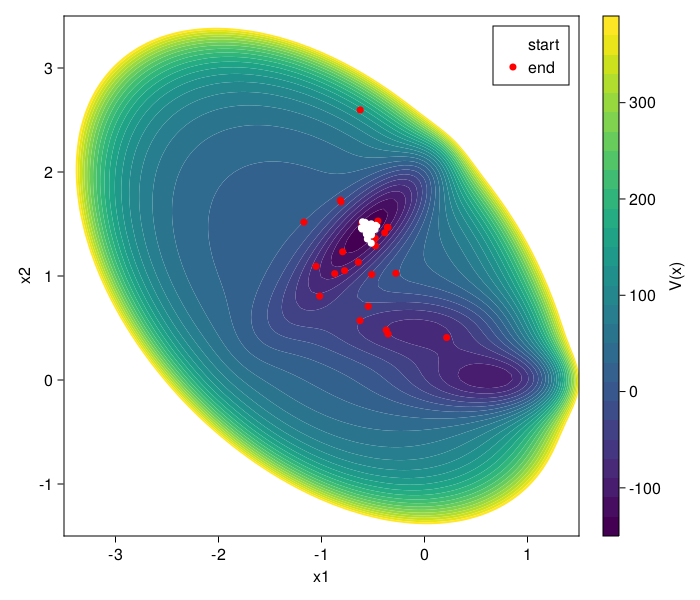

In [79]:
f1 = plot_md_trajectory(ens1, ctr_grid, fill=true, lvls=ctr_lvls, showpath=false)

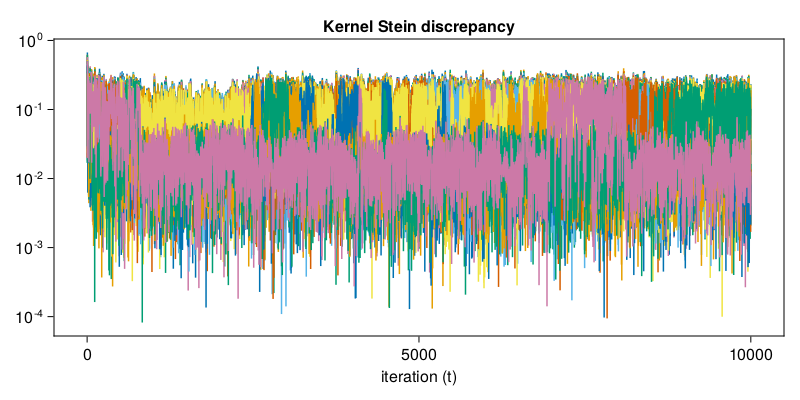

In [31]:

f1b, _ = plot_step(ens1, "Kernel Stein discrepancy", logscl=true)
f1b

In [32]:
# subsample to obtain training data
x_train = [[1.0, 0.0], [0.5, 0.0], [0.0, 0.0], [-0.5, 0.0], [-1.0, 0.0],
           [1.0, 0.5], [0.5, 0.5], [0.0, 0.5], [-0.5, 0.5], [-1.0, 0.5],
           [0.5, 1.0], [0.0, 1.0], [-0.5, 1.0], [-1.0, 1.0], [-1.5, 1.0],
           [0.5, 1.5], [0.0, 1.5], [-0.5, 1.5], [-1.0, 1.5], [-1.5, 1.5], 
           [0.0, 2.0], [-0.5, 2.0], [-1.0, 2.0], [-1.5, 2.0], [-2.0, 2.0]]
coords_train = [SVector(x[1], x[2])u"nm" for x in x_train]
ntrain = length(x_train)
atoms_train = [Atom(mass=atom_mass, σ=1.0u"nm", ϵ=1.0u"kJ * mol^-1") for i in 1:ntrain]

# define initial ensemble
ens2 = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(ref,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
    loggers=(
        coords=CoordinateLogger(1; dims=2),
        ksd=StepComponentLogger(1; dims=2),
    )
) for (atoms_i, coords_i) in zip(atoms_train, coords_train)]

25-element Vector{System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, NamedT

In [33]:
# run simulation - this will take a few seconds
simulate!(ens2, sim_svgd, 10_000)

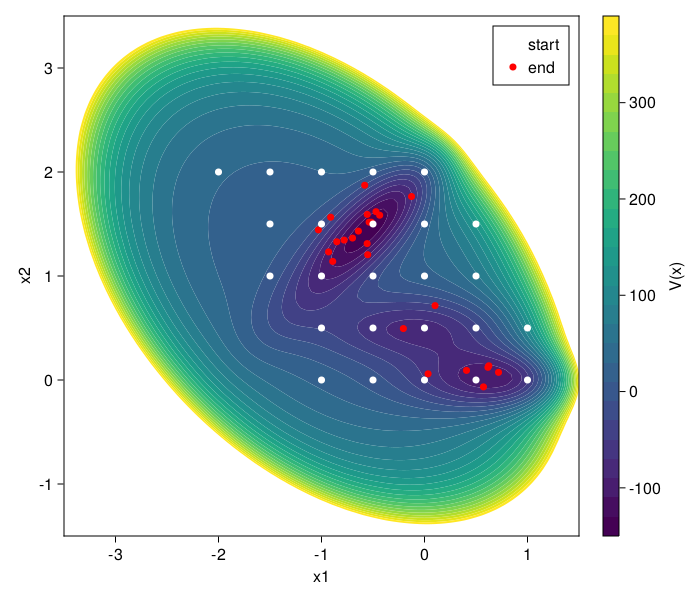

In [34]:
f2 = plot_md_trajectory(ens2, ctr_grid, fill=true, lvls=ctr_lvls, showpath=false)


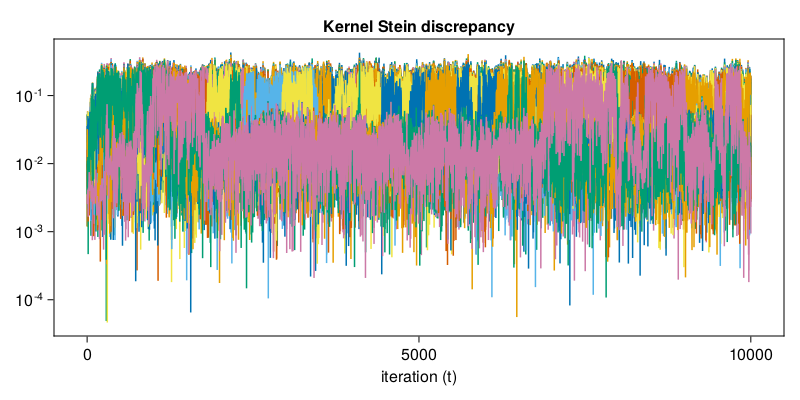

In [35]:
f2b, _ = plot_step(ens2, "Kernel Stein discrepancy", logscl=true)
f2b